# First assignment: Compute different measures on a realistic graph

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy
import collections


## Try synthetic graph

In [9]:
n = 50 # number of nodes
p = 0.07 # propability 

G = nx.erdos_renyi_graph(n, p)


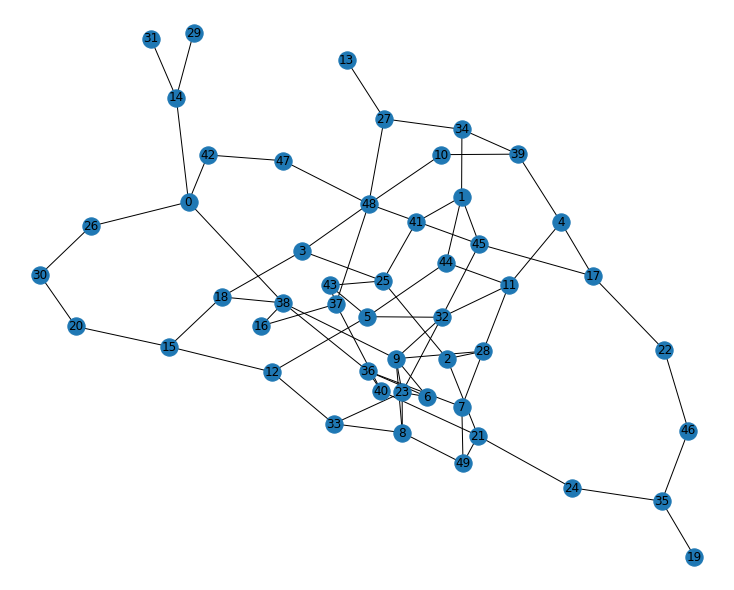

In [10]:
# draw
plt.figure(figsize=(10, 8))
nx.draw(G, with_labels=True)
plt.show()

# poi con quello reale bisogna usare Gephi

### Compute metrics

#### Find the largest connected component if necessary

In [12]:
if not nx.is_connected(G):
    print("Diameter: graph not connected!")
    G =  G.subgraph(sorted(nx.connected_components(G), key=len, reverse=True)[0]).copy()

#### 1.Does the graph have the same characteristics of a random or a power-law network?

In [13]:

# Degree distribution
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots()
plt.bar(deg, cnt, width=0.80, color="b")

plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
ax.set_xticks([d for d in deg])
ax.set_xticklabels(deg)

plt.show()

NameError: name 'collections' is not defined

#### 2. Which are the most important nodes, with respect to a given centrality measure?

#### 3. Are the paths short with respect to the size of the network?


In [ ]:
print("Diameter: ", nx.diameter(G))

#### 4. Is the network dense?


#### 5. Is the network assortative?